In [1]:
import joblib
import numpy as np
import joblib
import numpy as np
import networkx as nx
import yaml
import utilities as ut 
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

import opt_tools as optools


[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'lilucas'

In [3]:
config_files = {
                    'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
                    'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
                    'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
                }
configs = ut.load_configs(config_files)

hyperparams_diroca = configs['hyperparams_diroca']
hyperparams_gradca = configs['hyperparams_gradca']
hyperparams_baryca = configs['hyperparams_baryca']

In [4]:
all_data   = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

Dll_obs     = all_data['LLmodel']['data'][None]
Dhl_obs     = all_data['HLmodel']['data'][None]
folds_path  = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'], hyperparams_diroca['seed'], folds_path)

Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'


In [5]:
# # --- Quick Sanity Check: GradCA vs. DIROCA with radius=0 ---

# print("--- Running a short test to compare GradCA and DIROCA with radius=0 ---")

# # Use only the first fold for a quick run
# fold_info = saved_folds[0]
# short_max_iter = 5000 

# # --- 1. Run GradCA ---
# print("\nRunning GradCA...")
# gradca_params = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_gradca)
# gradca_args = gradca_params.copy()
# gradca_args['max_iter'] = short_max_iter 
# gradca_args['tol'] = 0.00001
# gradca_args.pop('k_folds', None)

# # --- THIS IS THE CHANGE: Capture the monitor object ---
# _, T_gradca, monitor_gradca = optools.run_erica_optimization(**gradca_args)


# # --- 2. Run DIROCA with radius = 0 AND same num_steps_min ---
# print("\nRunning DIROCA with radius = 0...")
# diroca_params = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)
# diroca_params['theta_hatL']['radius'] = 0.0
# diroca_params['theta_hatH']['radius'] = 0.0
# diroca_params['num_steps_min'] = 1  # Same as GradCA
# diroca_args = diroca_params.copy()
# diroca_args['max_iter'] = short_max_iter
# diroca_args.pop('k_folds', None)

# # --- THIS IS THE CHANGE: Capture the monitor object ---
# _, T_diroca_zero, monitor_diroca = optools.run_erica_optimization(**diroca_args)


# # --- 3. Compare the Results ---
# difference = np.linalg.norm(T_gradca - T_diroca_zero, 'fro')
# print("\n--- Comparison ---")
# print(f"Frobenius norm of the difference between the two T matrices: {difference:.6f}")
# if difference < 1e-3:
#     print("\nConclusion: The methods are computationally equivalent, as expected.")
# else:
#     print("\nConclusion: The methods produced different results, which is unexpected.")


# # --- 4. Generate the Convergence Plots ---
# print("\n--- Generating Convergence Plot for GradCA ---")
# monitor_gradca.plot_run_summary()

# print("\n--- Generating Convergence Plot for DIROCA (radius=0) ---")
# monitor_diroca.plot_run_summary()

In [6]:
# # --- Single Cell: GRADCA Optimization + Evaluation ---

# import joblib
# import numpy as np
# import pandas as pd
# import os
# import utilities as ut
# import opt_tools as optools
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# # Configuration
# experiment = 'slc'  # Change this to your experiment name
# output_dir = f"data/{experiment}/results"
# os.makedirs(output_dir, exist_ok=True)

# print(f"=== Running GRADCA Optimization + Evaluation for {experiment} ===")

# # 1. Setup experiment data
# print("1. Loading experiment data...")
# # Load configuration files
# config_files = {
#     'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
#     'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
#     'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
# }
# configs = ut.load_configs(config_files)

# # Load data
# all_data = ut.load_all_data(experiment)
# all_data['experiment_name'] = experiment

# # Prepare cross-validation folds
# Dll_obs = all_data['LLmodel']['data'][None]
# Dhl_obs = all_data['HLmodel']['data'][None]
# folds_path = f"data/{experiment}/cv_folds.pkl"
# saved_folds = ut.prepare_cv_folds(Dll_obs, configs['hyperparams_diroca']['k_folds'], 
#                                 configs['hyperparams_diroca']['seed'], folds_path)

# hyperparams_gradca = configs['hyperparams_gradca']

# # 2. Run GRADCA optimization only
# print("2. Running GRADCA optimization...")
# gradca_cv_results = {}

# for i, fold_info in enumerate(saved_folds):
#     print(f"  - Fold {i+1}/{len(saved_folds)}")
    
#     # Assemble parameters for this specific run
#     params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_gradca)
#     opt_args = params_for_this_run.copy()
#     opt_args.pop('k_folds', None)
    
#     # Run the optimization
#     trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)

#     # Store the results
#     gradca_cv_results[f'fold_{i}'] = {
#         'gradca_run': {
#             'T_matrix': trained_T,
#             'test_indices': fold_info['test'] 
#         }
#     }

# # 3. Save GRADCA results
# print("3. Saving GRADCA results...")
# # gradca_output_path = os.path.join(output_dir, "gradca_cv_results.pkl")
# # joblib.dump(gradca_cv_results, gradca_output_path)
# # print(f"   Saved to: {gradca_output_path}")

# # 4. Run evaluation (adapted from your evaluation script)
# print("4. Running evaluation...")

# # Load necessary data for evaluation
# Dll_samples = all_data['LLmodel']['data']
# Dhl_samples = all_data['HLmodel']['data']
# I_ll_relevant = all_data['LLmodel']['intervention_set']
# omega = all_data['abstraction_data']['omega']
# ll_var_names = list(all_data['LLmodel']['graph'].nodes())
# hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# # Define base covariance matrices
# base_sigma_L = np.eye(len(all_data['LLmodel']['graph'].nodes()))
# base_sigma_H = np.eye(len(all_data['HLmodel']['graph'].nodes()))

# # Evaluation parameters
# alpha_values = np.linspace(0, 1.0, 10)
# noise_levels = np.linspace(0, 5.0 if experiment == 'slc' else 10.0, 20)
# num_trials = 20
# zero_mean = True
# shift_type = 'additive'
# distribution = 'gaussian'

# print(f"   - Alpha values: {len(alpha_values)} points")
# print(f"   - Noise levels: {len(noise_levels)} points")
# print(f"   - Trials: {num_trials}")

# # Import evaluation functions
# import modularised_utils as mut

# def apply_shift(clean_data, shift_config, all_var_names, model_level):
#     """Apply contamination to test data."""
#     shift_type = shift_config.get('type')
#     dist_type = shift_config.get('distribution', 'gaussian')
#     n_samples, n_dims = clean_data.shape
    
#     level_key = 'll_params' if model_level == 'L' else 'hl_params'
#     params = shift_config.get(level_key, {})
    
#     noise_matrix = np.zeros_like(clean_data)
#     if dist_type == 'gaussian':
#         mu = np.array(params.get('mu', np.zeros(n_dims)))
#         sigma_def = params.get('sigma', np.eye(n_dims))
#         sigma = np.diag(np.array(sigma_def)) if np.array(sigma_def).ndim == 1 else np.array(sigma_def)
#         noise_matrix = np.random.multivariate_normal(mean=mu, cov=sigma, size=n_samples)
    
#     final_noise = np.zeros_like(clean_data)
#     vars_to_affect = params.get('apply_to_vars')
    
#     if vars_to_affect is None:
#         final_noise = noise_matrix
#     else:
#         try:
#             indices_to_affect = [all_var_names.index(var) for var in vars_to_affect]
#             final_noise[:, indices_to_affect] = noise_matrix[:, indices_to_affect]
#         except ValueError:
#             return clean_data
    
#     if shift_type == 'additive':
#         return clean_data + final_noise
#     elif shift_type == 'multiplicative':
#         return clean_data * final_noise
#     else:
#         raise ValueError(f"Unknown shift type: {shift_type}")

# def apply_huber_contamination(clean_data, alpha, shift_config, all_var_names, model_level, seed=42):
#     """Contaminate dataset using Huber model."""
#     if not (0 <= alpha <= 1):
#         raise ValueError("Alpha must be between 0 and 1.")
#     if alpha == 0:
#         return clean_data
    
#     noisy_data = apply_shift(clean_data, shift_config, all_var_names, model_level)
#     if alpha == 1:
#         return noisy_data
    
#     n_samples = clean_data.shape[0]
#     n_to_contaminate = int(alpha * n_samples)
#     indices_to_replace = np.random.choice(n_samples, n_to_contaminate, replace=False)
    
#     contaminated_data = clean_data.copy()
#     contaminated_data[indices_to_replace] = noisy_data[indices_to_replace]
#     return contaminated_data

# def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
#     """Calculate abstraction error for given T matrix on test set."""
#     mu_L_test = np.mean(Dll_test, axis=0)
#     Sigma_L_test = np.cov(Dll_test, rowvar=False)
#     mu_H_test = np.mean(Dhl_test, axis=0)
#     Sigma_H_test = np.cov(Dhl_test, rowvar=False)
    
#     mu_V_predicted = mu_L_test @ T_matrix.T
#     Sigma_V_predicted = T_matrix @ Sigma_L_test @ T_matrix.T
    
#     try:
#         wasserstein_dist = np.sqrt(mut.compute_wasserstein(mu_V_predicted, Sigma_V_predicted, mu_H_test, Sigma_H_test))
#     except Exception as e:
#         print(f"  - Warning: Could not compute Wasserstein distance. Error: {e}. Returning NaN.")
#         return np.nan
    
#     return wasserstein_dist

# # Run evaluation
# evaluation_records = []

# print("   - Starting evaluation loop...")
# for alpha in tqdm(alpha_values, desc="Alpha Levels"):
#     for scale in noise_levels:
#         for trial in range(num_trials):
#             for i, fold_info in enumerate(saved_folds):
#                 fold_results = gradca_cv_results[f'fold_{i}']
#                 run_data = fold_results['gradca_run']
                
#                 T_learned = run_data['T_matrix']
#                 test_indices = run_data['test_indices']
                
#                 errors_per_intervention = []
#                 for iota in I_ll_relevant:
#                     Dll_test_clean = Dll_samples[iota][test_indices]
#                     Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                    
#                     # Configure shift parameters
#                     if zero_mean:
#                         mu_scale_L = np.zeros(base_sigma_L.shape[0])
#                         mu_scale_H = np.zeros(base_sigma_H.shape[0])
#                     else:
#                         mu_scale_L = np.ones(base_sigma_L.shape[0]) * scale
#                         mu_scale_H = np.ones(base_sigma_H.shape[0]) * scale
                    
#                     sigma_scale_L = base_sigma_L * (scale**2)
#                     sigma_scale_H = base_sigma_H * (scale**2)
                    
#                     shift_config = {
#                         'type': shift_type, 
#                         'distribution': distribution,
#                         'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
#                         'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H}
#                     }
                    
#                     Dll_test_contaminated = apply_huber_contamination(
#                         Dll_test_clean, alpha, shift_config, ll_var_names, 'L', seed=trial)
#                     Dhl_test_contaminated = apply_huber_contamination(
#                         Dhl_test_clean, alpha, shift_config, hl_var_names, 'H', seed=trial)
                    
#                     error = calculate_abstraction_error(T_learned, Dll_test_contaminated, Dhl_test_contaminated)
#                     if not np.isnan(error):
#                         errors_per_intervention.append(error)
                
#                 avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                
#                 record = {
#                     'method': 'GradCA',
#                     'alpha': alpha,
#                     'noise_scale': scale,
#                     'trial': trial,
#                     'fold': i,
#                     'error': avg_error
#                 }
#                 evaluation_records.append(record)

# # 5. Save evaluation results
# print("5. Saving evaluation results...")
# final_results_df = pd.DataFrame(evaluation_records)

# evaluation_dir = f"data/{experiment}/evaluation_results"
# os.makedirs(evaluation_dir, exist_ok=True)

# timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
# alpha_min, alpha_max = alpha_values[0], alpha_values[-1]
# noise_min, noise_max = noise_levels[0], noise_levels[-1]
# filename = f"evaluation_gradca_{shift_type}_{distribution}_alpha{len(alpha_values)}-{alpha_min:.1f}-{alpha_max:.1f}_noise{len(noise_levels)}-{noise_min:.1f}-{noise_max:.1f}_trials{num_trials}_zero_mean{zero_mean}_{timestamp}.csv"
# evaluation_output_path = os.path.join(evaluation_dir, filename)

# final_results_df.to_csv(evaluation_output_path, index=False)
# print(f"   Saved to: {evaluation_output_path}")

# # 6. Print summary
# print("\n=== GRADCA Optimization + Evaluation Complete ===")
# print(f"Experiment: {experiment}")
# print(f"Optimization results: {gradca_output_path}")
# print(f"Evaluation results: {evaluation_output_path}")
# print(f"Total evaluation records: {len(final_results_df)}")
# print(f"Methods evaluated: {final_results_df['method'].nunique()}")
# print(f"Unique alpha values: {final_results_df['alpha'].nunique()}")
# print(f"Unique noise scales: {final_results_df['noise_scale'].nunique()}")

# # Return results for further analysis
# print("\nResults DataFrame ready for analysis!")

In [7]:
# df_clean             = final_results_df[final_results_df['alpha']==0.0]
# summary_stats        = df_clean.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
# summary_stats['sem'] = summary_stats['std']# / np.sqrt(summary_stats['count'])

# print("--- Final Summary (Mean Error ± SEM) ---")

# print("\n" + "="*65)
# print(f"{'Method/Run':<45} | {'Mean ± Std'}")
# print("="*65)

# for method_name, row in summary_stats.iterrows():
#     mean_val = row['mean']

#     sem_val = row['sem']
    
#     print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

# print("="*65)

In [8]:
# # --- GRADCA Hyperparameter Grid Search ---

# import joblib
# import numpy as np
# import pandas as pd
# import os
# import utilities as ut
# import opt_tools as optools
# from tqdm import tqdm
# import warnings
# from itertools import product
# warnings.filterwarnings('ignore')

# # Configuration
# experiment = 'slc'  # Change this to your experiment name
# print(f"=== Running GRADCA Hyperparameter Grid Search for {experiment} ===")

# # 1. Setup experiment data
# print("1. Loading experiment data...")
# config_files = {
#     'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
#     'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
#     'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
# }
# configs = ut.load_configs(config_files)

# # Load data
# all_data = ut.load_all_data(experiment)
# all_data['experiment_name'] = experiment

# # Prepare cross-validation folds
# Dll_obs = all_data['LLmodel']['data'][None]
# Dhl_obs = all_data['HLmodel']['data'][None]
# folds_path = f"data/{experiment}/cv_folds.pkl"
# saved_folds = ut.prepare_cv_folds(Dll_obs, configs['hyperparams_diroca']['k_folds'], 
#                                 configs['hyperparams_diroca']['seed'], folds_path)

# # 2. Define grid search parameters
# print("2. Setting up grid search...")
# grid_params = {
#     'eta_min': [0.001],
#     'tol': [0.0000001], 
#     'max_iter': [100000],  # Fixed at 5000
#     'xavier': [True]
# }

# # Generate all combinations
# param_names = list(grid_params.keys())
# param_values = list(grid_params.values())
# combinations = list(product(*param_values))

# print(f"   Testing {len(combinations)} parameter combinations:")
# for i, combo in enumerate(combinations):
#     param_dict = dict(zip(param_names, combo))
#     print(f"   {i+1}. eta_min={param_dict['eta_min']}, tol={param_dict['tol']}, max_iter={param_dict['max_iter']}")

# # 3. Run grid search
# print("3. Running grid search...")
# grid_results = []

# for combo_idx, combo in enumerate(combinations):
#     param_dict = dict(zip(param_names, combo))
#     print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
#     print(f"Parameters: {param_dict}")
    
#     # Create config with current parameters
#     current_config = configs['hyperparams_gradca'].copy()
#     current_config.update(param_dict)
    
#     # Run optimization for all folds
#     fold_results = []
    
#     for fold_idx, fold_info in enumerate(saved_folds):
#         print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")
        
#         # Assemble parameters for this specific run
#         params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, current_config)
#         opt_args = params_for_this_run.copy()
#         opt_args.pop('k_folds', None)
        
#         # Run the optimization
#         trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)
        
#         # Store fold result
#         fold_results.append({
#             'T_matrix': trained_T,
#             'test_indices': fold_info['test']
#         })
    
#     # 4. Quick evaluation (clean data only, alpha=0.0)
#     print(f"  - Evaluating on clean data (alpha=0.0)...")
    
#     # Load necessary data for evaluation
#     Dll_samples = all_data['LLmodel']['data']
#     Dhl_samples = all_data['HLmodel']['data']
#     I_ll_relevant = all_data['LLmodel']['intervention_set']
#     omega = all_data['abstraction_data']['omega']
    
#     # Quick evaluation parameters (clean data only)
#     alpha_values = [0.0]  # Only clean data
#     noise_levels = [0.0]  # No noise
#     num_trials = 5  # Reduced for speed
    
#     # Import evaluation functions
#     import modularised_utils as mut
    
#     def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
#         """Calculate abstraction error for given T matrix on test set."""
#         mu_L_test = np.mean(Dll_test, axis=0)
#         Sigma_L_test = np.cov(Dll_test, rowvar=False)
#         mu_H_test = np.mean(Dhl_test, axis=0)
#         Sigma_H_test = np.cov(Dhl_test, rowvar=False)
        
#         mu_V_predicted = mu_L_test @ T_matrix.T
#         Sigma_V_predicted = T_matrix @ Sigma_L_test @ T_matrix.T
        
#         try:
#             wasserstein_dist = np.sqrt(mut.compute_wasserstein(mu_V_predicted, Sigma_V_predicted, mu_H_test, Sigma_H_test))
#         except Exception as e:
#             print(f"    Warning: Could not compute Wasserstein distance. Error: {e}. Returning NaN.")
#             return np.nan
        
#         return wasserstein_dist
    
#     # Evaluate all folds
#     fold_errors = []
#     for fold_idx, fold_result in enumerate(fold_results):
#         T_learned = fold_result['T_matrix']
#         test_indices = fold_result['test_indices']
        
#         errors_per_intervention = []
#         for iota in I_ll_relevant:
#             Dll_test_clean = Dll_samples[iota][test_indices]
#             Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            
#             error = calculate_abstraction_error(T_learned, Dll_test_clean, Dhl_test_clean)
#             if not np.isnan(error):
#                 errors_per_intervention.append(error)
        
#         avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
#         fold_errors.append(avg_error)
    
#     # Calculate mean error across folds
#     mean_error = np.mean([e for e in fold_errors if not np.isnan(e)])
#     std_error = np.std([e for e in fold_errors if not np.isnan(e)])
    
#     print(f"  - Mean error: {mean_error:.6f} ± {std_error:.6f}")
    
#     # Store result
#     grid_results.append({
#         'params': param_dict,
#         'mean_error': mean_error,
#         'std_error': std_error,
#         'fold_errors': fold_errors
#     })

# # 5. Find best parameters
# print("\n4. Analyzing results...")
# best_idx = np.argmin([r['mean_error'] for r in grid_results])
# best_result = grid_results[best_idx]

# print(f"\n=== GRID SEARCH COMPLETE ===")
# print(f"Best parameters found:")
# print(f"  eta_min: {best_result['params']['eta_min']}")
# print(f"  tol: {best_result['params']['tol']}")
# print(f"  max_iter: {best_result['params']['max_iter']}")
# print(f"  Mean error: {best_result['mean_error']:.6f} ± {best_result['std_error']:.6f}")

# # 6. Print full results table
# print(f"\n=== FULL RESULTS TABLE ===")
# print(f"{'eta_min':<8} | {'tol':<10} | {'max_iter':<8} | {'Mean Error':<12} | {'Std Error':<12}")
# print("-" * 60)

# for result in grid_results:
#     params = result['params']
#     print(f"{params['eta_min']:<8} | {params['tol']:<10} | {params['max_iter']:<8} | {result['mean_error']:<12.6f} | {result['std_error']:<12.6f}")

# print("-" * 60)
# print(f"Best combination: {best_idx+1}/{len(combinations)}")

# # Store best parameters for easy access
# best_params = best_result['params']
# print(f"\nBest parameters dictionary:")
# print(f"best_params = {best_params}")

In [9]:
# # --- GRADCA Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

# import joblib
# import numpy as np
# import pandas as pd
# import os
# import utilities as ut
# import opt_tools as optools
# from tqdm import tqdm
# import warnings
# from itertools import product
# from run_evaluation import apply_shift, apply_huber_contamination
# import modularised_utils as mut
# warnings.filterwarnings('ignore')

# # Configuration
# experiment = 'lilucas'  # Change this to your experiment name
# print(f"=== Running GRADCA Hyperparameter Grid Search for {experiment} ===")

# # 1. Setup experiment data
# print("1. Loading experiment data...")
# config_files = {
#     'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
#     'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
#     'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
# }
# configs = ut.load_configs(config_files)

# # Load data
# all_data = ut.load_all_data(experiment)
# all_data['experiment_name'] = experiment

# # Prepare cross-validation folds
# Dll_obs = all_data['LLmodel']['data'][None]
# Dhl_obs = all_data['HLmodel']['data'][None]
# folds_path = f"data/{experiment}/cv_folds.pkl"
# saved_folds = ut.prepare_cv_folds(Dll_obs, configs['hyperparams_diroca']['k_folds'], 
#                                 configs['hyperparams_diroca']['seed'], folds_path)

# # 2. Define grid search parameters
# print("2. Setting up grid search...")
# if experiment == 'slc':
#     grid_params = {
#         'eta_min': [0.001],
#         'tol': [0.0000001], 
#         'max_iter': [100000],
#         'xavier': [True]
#     }
# elif experiment == 'lilucas':
#     grid_params = {
#         'eta_min': [0.001],
#         'tol': [0.00001], 
#         'max_iter': [50000],
#         'xavier': [False]
#     }
#     # grid_params = {
#     #     'eta_min': [0.00001, 0.000001],
#     #     'tol': [0.00001, 0.000001], 
#     #     'max_iter': [50000],
#     #     'xavier': [False, True]
#     # }

# # Generate all combinations
# param_names = list(grid_params.keys())
# param_values = list(grid_params.values())
# combinations = list(product(*param_values))

# print(f"   Testing {len(combinations)} parameter combinations:")
# for i, combo in enumerate(combinations):
#     param_dict = dict(zip(param_names, combo))
#     print(f"   {i+1}. eta_min={param_dict['eta_min']}, tol={param_dict['tol']}, max_iter={param_dict['max_iter']}")

# # 3. Run grid search
# print("3. Running grid search...")
# grid_results = []

# for combo_idx, combo in enumerate(combinations):
#     param_dict = dict(zip(param_names, combo))
#     print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
#     print(f"Parameters: {param_dict}")
    
#     # Create config with current parameters
#     current_config = configs['hyperparams_gradca'].copy()
#     current_config.update(param_dict)
    
#     # Run optimization for all folds
#     fold_results = []
    
#     for fold_idx, fold_info in enumerate(saved_folds):
#         print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")
        
#         # Assemble parameters for this specific run
#         params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, current_config)
#         opt_args = params_for_this_run.copy()
#         opt_args.pop('k_folds', None)
        
#         # Run the optimization
#         trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)
        
#         # Store fold result
#         fold_results.append({
#             'T_matrix': trained_T,
#             'test_indices': fold_info['test']
#         })
    
#     # 4. Quick evaluation (0-shift and rho-shift cases)
#     print(f"  - Evaluating on 0-shift case (alpha=0.0, noise_scale=0.0)...")
    
#     # Load necessary data for evaluation
#     Dll_samples = all_data['LLmodel']['data']
#     Dhl_samples = all_data['HLmodel']['data']
#     I_ll_relevant = all_data['LLmodel']['intervention_set']
#     omega = all_data['abstraction_data']['omega']
    
#     def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
#         """Calculate abstraction error for given T matrix on test set."""
#         mu_L_test = np.mean(Dll_test, axis=0)
#         Sigma_L_test = np.cov(Dll_test, rowvar=False)
#         mu_H_test = np.mean(Dhl_test, axis=0)
#         Sigma_H_test = np.cov(Dhl_test, rowvar=False)
        
#         mu_V_predicted = mu_L_test @ T_matrix.T
#         Sigma_V_predicted = T_matrix @ Sigma_L_test @ T_matrix.T
        
#         try:
#             wasserstein_dist = np.sqrt(mut.compute_wasserstein(mu_V_predicted, Sigma_V_predicted, mu_H_test, Sigma_H_test))
#         except Exception as e:
#             print(f"    Warning: Could not compute Wasserstein distance. Error: {e}. Returning NaN.")
#             return np.nan
        
#         return wasserstein_dist

#     # Evaluate all folds for 0-shift case (alpha=0.0, noise_scale=0.0)
#     fold_errors_0shift = []
#     for fold_idx, fold_result in enumerate(fold_results):
#         T_learned = fold_result['T_matrix']
#         test_indices = fold_result['test_indices']
        
#         errors_per_intervention = []
#         for iota in I_ll_relevant:
#             Dll_test_clean = Dll_samples[iota][test_indices]
#             Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            
#             error = calculate_abstraction_error(T_learned, Dll_test_clean, Dhl_test_clean)
#             if not np.isnan(error):
#                 errors_per_intervention.append(error)
        
#         avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
#         fold_errors_0shift.append(avg_error)

#     # Calculate mean error across folds for 0-shift
#     mean_error_0shift = np.mean([e for e in fold_errors_0shift if not np.isnan(e)])
#     std_error_0shift = np.std([e for e in fold_errors_0shift if not np.isnan(e)])

#     print(f"  - 0-shift mean error: {mean_error_0shift:.6f} ± {std_error_0shift:.6f}")

#     # Now evaluate rho-shift case (alpha=1.0, noise_scale=5.0 for SLC, 10.0 for others)
#     print(f"  - Evaluating on rho-shift case (alpha=1.0, noise_scale={'5.0' if experiment == 'slc' else '10.0'})...")

#     # Get variable names for contamination
#     ll_var_names = list(all_data['LLmodel']['scm_instances'][None].variables)
#     hl_var_names = list(all_data['HLmodel']['scm_instances'][None].variables)

#     # Get base covariance matrices for contamination
#     base_sigma_L = all_data['LLmodel']['noise_dist']['sigma']
#     base_sigma_H = all_data['HLmodel']['noise_dist']['sigma']

#     # Set rho-shift parameters
#     alpha_rho = 1.0
#     noise_scale_rho = 5.0 if experiment == 'slc' else 10.0

#     # Configure shift parameters for rho-shift
#     mu_scale_L = np.zeros(base_sigma_L.shape[0])
#     mu_scale_H = np.zeros(base_sigma_H.shape[0])
#     sigma_scale_L = base_sigma_L * (noise_scale_rho**2)
#     sigma_scale_H = base_sigma_H * (noise_scale_rho**2)

#     shift_config = {
#         'type': 'additive', 
#         'distribution': 'gaussian',
#         'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
#         'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H}
#     }

#     # Evaluate all folds for rho-shift case
#     fold_errors_rhoshift = []
#     for fold_idx, fold_result in enumerate(fold_results):
#         T_learned = fold_result['T_matrix']
#         test_indices = fold_result['test_indices']
        
#         errors_per_intervention = []
#         for iota in I_ll_relevant:
#             Dll_test_clean = Dll_samples[iota][test_indices]
#             Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            
#             # Apply contamination for rho-shift case
#             Dll_test_contaminated = apply_huber_contamination(
#                 Dll_test_clean, alpha_rho, shift_config, ll_var_names, 'L', seed=fold_idx)
#             Dhl_test_contaminated = apply_huber_contamination(
#                 Dhl_test_clean, alpha_rho, shift_config, hl_var_names, 'H', seed=fold_idx)
            
#             error = calculate_abstraction_error(T_learned, Dll_test_contaminated, Dhl_test_contaminated)
#             if not np.isnan(error):
#                 errors_per_intervention.append(error)
        
#         avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
#         fold_errors_rhoshift.append(avg_error)

#     # Calculate mean error across folds for rho-shift
#     mean_error_rhoshift = np.mean([e for e in fold_errors_rhoshift if not np.isnan(e)])
#     std_error_rhoshift = np.std([e for e in fold_errors_rhoshift if not np.isnan(e)])

#     print(f"  - Rho-shift mean error: {mean_error_rhoshift:.6f} ± {std_error_rhoshift:.6f}")

#     # Store result with both evaluations
#     grid_results.append({
#         'params': param_dict,
#         'mean_error_0shift': mean_error_0shift,
#         'std_error_0shift': std_error_0shift,
#         'fold_errors_0shift': fold_errors_0shift,
#         'mean_error_rhoshift': mean_error_rhoshift,
#         'std_error_rhoshift': std_error_rhoshift,
#         'fold_errors_rhoshift': fold_errors_rhoshift
#     })

# # 5. Find best parameters
# print("\n4. Analyzing results...")

# # Best for 0-shift
# best_idx_0shift = np.argmin([r['mean_error_0shift'] for r in grid_results])
# best_result_0shift = grid_results[best_idx_0shift]

# # Best for rho-shift
# best_idx_rhoshift = np.argmin([r['mean_error_rhoshift'] for r in grid_results])
# best_result_rhoshift = grid_results[best_idx_rhoshift]

# print(f"\n=== GRID SEARCH COMPLETE ===")
# print(f"Best parameters for 0-shift:")
# print(f"  eta_min: {best_result_0shift['params']['eta_min']}")
# print(f"  tol: {best_result_0shift['params']['tol']}")
# print(f"  max_iter: {best_result_0shift['params']['max_iter']}")
# print(f"  Mean error: {best_result_0shift['mean_error_0shift']:.6f} ± {best_result_0shift['std_error_0shift']:.6f}")

# print(f"\nBest parameters for rho-shift:")
# print(f"  eta_min: {best_result_rhoshift['params']['eta_min']}")
# print(f"  tol: {best_result_rhoshift['params']['tol']}")
# print(f"  max_iter: {best_result_rhoshift['params']['max_iter']}")
# print(f"  Mean error: {best_result_rhoshift['mean_error_rhoshift']:.6f} ± {best_result_rhoshift['std_error_rhoshift']:.6f}")

# # 6. Print full results table
# print(f"\n=== FULL RESULTS TABLE ===")
# print(f"{'eta_min':<8} | {'tol':<10} | {'max_iter':<8} | {'0-shift Error':<15} | {'Rho-shift Error':<15}")
# print("-" * 70)

# for result in grid_results:
#     params = result['params']
#     print(f"{params['eta_min']:<8} | {params['tol']:<10} | {params['max_iter']:<8} | "
#           f"{result['mean_error_0shift']:<15.6f} | {result['mean_error_rhoshift']:<15.6f}")

# print("-" * 70)
# print(f"Best 0-shift combination: {best_idx_0shift+1}/{len(combinations)}")
# print(f"Best rho-shift combination: {best_idx_rhoshift+1}/{len(combinations)}")

# # Store best parameters for easy access
# best_params_0shift = best_result_0shift['params']
# best_params_rhoshift = best_result_rhoshift['params']
# print(f"\nBest parameters for 0-shift:")
# print(f"best_params_0shift = {best_params_0shift}")
# print(f"\nBest parameters for rho-shift:")
# print(f"best_params_rhoshift = {best_params_rhoshift}")

# # Save results
# output_dir = f"data/{experiment}/results"
# os.makedirs(output_dir, exist_ok=True)
# joblib.dump(grid_results, os.path.join(output_dir, "gradca_grid_search_with_rhoshift.pkl"))
# print(f"\nResults saved to {output_dir}/gradca_grid_search_with_rhoshift.pkl")

In [10]:
# --- GRADCA Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

import joblib
import numpy as np
import pandas as pd
import os
import utilities as ut
import opt_tools as optools
from tqdm import tqdm
import warnings
from itertools import product
from run_evaluation import apply_shift, apply_huber_contamination
import modularised_utils as mut
warnings.filterwarnings('ignore')

# Configuration
experiment = 'lilucas'
print(f"=== Running GRADCA Hyperparameter Grid Search for {experiment} ===")

# 1. Setup experiment data
print("1. Loading experiment data...")
config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
}
configs = ut.load_configs(config_files)

# Load data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare cross-validation folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, configs['hyperparams_diroca']['k_folds'], 
                                  configs['hyperparams_diroca']['seed'], folds_path)


# 2. Define grid search parameters
print("2. Setting up grid search...")
if experiment == 'slc':
    grid_params = {
        'eta_min': [0.001],
        'tol': [0.0000001],
        'max_iter': [100000],
        'xavier': [True]
    }
elif experiment == 'lilucas':
    # grid_params = {
    #     'eta_min': [0.001],
    #     'tol': [0.0001],
    #     'max_iter': [5000],
    #     'xavier': [False]
    # }
    grid_params = {
                        'eta_min':      [0.0007],#, 0.001],
                        'tol':          [2e-5],
                        'max_iter':     [1000],
                        'num_steps_min':[1],
                        'xavier':       [False],
                        'seed':         [0]
                    }
    


# Generate all combinations
param_names = list(grid_params.keys())
param_values = list(grid_params.values())
combinations = list(product(*param_values))

print(f"   Testing {len(combinations)} parameter combinations:")
for i, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"   {i+1}. eta_min={param_dict['eta_min']}, tol={param_dict['tol']}, max_iter={param_dict['max_iter']}")

# ---------- NEW: helpers & fixed data used in eval ----------
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
    """W2 error between predicted HL moments (from LL via T) and true HL moments."""
    mu_L_test = np.mean(Dll_test, axis=0)
    Sigma_L_test = np.cov(Dll_test, rowvar=False)
    mu_H_test = np.mean(Dhl_test, axis=0)
    Sigma_H_test = np.cov(Dhl_test, rowvar=False)
    mu_V_pred = mu_L_test @ T_matrix.T
    Sigma_V_pred = T_matrix @ Sigma_L_test @ T_matrix.T
    return float(np.sqrt(mut.compute_wasserstein(mu_V_pred, Sigma_V_pred, mu_H_test, Sigma_H_test)))

# Optional: CSV log for per-fold metrics
per_fold_log_path = f"data/{experiment}/results/gradca_grid_per_fold.csv"
os.makedirs(os.path.dirname(per_fold_log_path), exist_ok=True)
if not os.path.exists(per_fold_log_path):
    with open(per_fold_log_path, "w") as f:
        f.write("combo_idx,fold_idx,eta_min,tol,max_iter,xavier,error_0shift,error_rhoshift\n")

# 3. Run grid search
print("3. Running grid search...")
grid_results = []

for combo_idx, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
    print(f"Parameters: {param_dict}")
    
    # Create config with current parameters
    current_config = configs['hyperparams_gradca'].copy()
    current_config.update(param_dict)
    
    # Run optimization for all folds
    fold_results = []
    fold_errors_0shift = []   # moved up so we can fill per fold
    fold_errors_rhoshift = [] # same for rho-shift

    # rho-shift params fixed here so we can reuse per fold
    base_sigma_L = all_data['LLmodel']['noise_dist']['sigma']
    base_sigma_H = all_data['HLmodel']['noise_dist']['sigma']
    alpha_rho = 1.0
    noise_scale_rho = 5.0 if experiment == 'slc' else 10.0
    mu_scale_L = np.zeros(base_sigma_L.shape[0])
    mu_scale_H = np.zeros(base_sigma_H.shape[0])
    sigma_scale_L = base_sigma_L * (noise_scale_rho**2)
    sigma_scale_H = base_sigma_H * (noise_scale_rho**2)
    shift_config = {
        'type': 'additive',
        'distribution': 'gaussian',
        'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
        'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H}
    }
    ll_var_names = list(all_data['LLmodel']['scm_instances'][None].variables)
    hl_var_names = list(all_data['HLmodel']['scm_instances'][None].variables)

    for fold_idx, fold_info in enumerate(saved_folds):
        print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

        # Assemble parameters for this specific run
        params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, current_config)
        opt_args = params_for_this_run.copy()
        opt_args.pop('k_folds', None)

        # Run the optimization
        trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)

        # --------- NEW: evaluate THIS FOLD immediately (0-shift & rho-shift) ---------
        test_indices = fold_info['test']
        # 0-shift
        errors_per_intervention = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            try:
                e0 = calculate_abstraction_error(trained_T, Dll_test_clean, Dhl_test_clean)
                errors_per_intervention.append(e0)
            except Exception as e:
                print(f"    Warning (0-shift, fold {fold_idx+1}): {e}")
        fold_err_0 = float(np.mean(errors_per_intervention)) if errors_per_intervention else np.nan
        fold_errors_0shift.append(fold_err_0)
        print(f"    Fold {fold_idx+1} 0-shift error: {fold_err_0:.6f}")

        # rho-shift (optional; comment out if you only want 0-shift)
        errors_per_intervention = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            Dll_test_cont = apply_huber_contamination(
                Dll_test_clean, alpha_rho, shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(
                Dhl_test_clean, alpha_rho, shift_config, hl_var_names, 'H', seed=fold_idx)
            try:
                er = calculate_abstraction_error(trained_T, Dll_test_cont, Dhl_test_cont)
                errors_per_intervention.append(er)
            except Exception as e:
                print(f"    Warning (rho-shift, fold {fold_idx+1}): {e}")
        fold_err_r = float(np.mean(errors_per_intervention)) if errors_per_intervention else np.nan
        fold_errors_rhoshift.append(fold_err_r)
        print(f"    Fold {fold_idx+1} rho-shift error: {fold_err_r:.6f}")

        # optional CSV log row
        with open(per_fold_log_path, "a") as f:
            f.write("{},{},{},{},{},{},{:.6f},{:.6f}\n".format(
                combo_idx+1, fold_idx+1,
                param_dict['eta_min'], param_dict['tol'], param_dict['max_iter'], param_dict['xavier'],
                fold_err_0, fold_err_r
            ))

        # Store fold result as before
        fold_results.append({
            'T_matrix': trained_T,
            'test_indices': test_indices
        })
        # break


    mean_error_0shift = np.nanmean(fold_errors_0shift)
    std_error_0shift = np.nanstd(fold_errors_0shift)
    print(f"  - 0-shift mean error: {mean_error_0shift:.6f} ± {std_error_0shift:.6f}")

    mean_error_rhoshift = np.nanmean(fold_errors_rhoshift)
    std_error_rhoshift = np.nanstd(fold_errors_rhoshift)
    print(f"  - Rho-shift mean error: {mean_error_rhoshift:.6f} ± {std_error_rhoshift:.6f}")

    grid_results.append({
        'params': param_dict,
        'mean_error_0shift': mean_error_0shift,
        'std_error_0shift': std_error_0shift,
        'fold_errors_0shift': fold_errors_0shift,
        'mean_error_rhoshift': mean_error_rhoshift,
        'std_error_rhoshift': std_error_rhoshift,
        'fold_errors_rhoshift': fold_errors_rhoshift
    })


=== Running GRADCA Hyperparameter Grid Search for lilucas ===
1. Loading experiment data...
Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'
2. Setting up grid search...
   Testing 1 parameter combinations:
   1. eta_min=0.0007, tol=2e-05, max_iter=1000
3. Running grid search...

--- Testing Combination 1/1 ---
Parameters: {'eta_min': 0.0007, 'tol': 2e-05, 'max_iter': 1000, 'num_steps_min': 1, 'xavier': False, 'seed': 0}
  - Fold 1/5
Running optimization on device: cpu


Optimizing:   6%|▌         | 57/1000 [00:02<00:38, 24.23it/s]


KeyboardInterrupt: 

In [11]:
# --- GRADCA (Empirical) Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

import utilities as ut
import opt_tools as optools
import modularised_utils as mut  # kept for parity (not strictly needed here)
import evaluation_utils as evut   # for compute_empirical_distance
from run_empirical_evaluation import apply_huber_contamination  # reuse your contamination logic

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'lilucas'
print(f"=== Running GRADCA (Empirical) Hyperparameter Grid Search for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

hyperparams_diroca = configs['hyperparams_diroca']
hyperparams_gradca = configs['hyperparams_gradca']  # base config to update per combo

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals (used by empirical optimizer)
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names (for selective contamination, if needed)
# Using graph node order, consistent with your empirical evaluation script
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Grid parameters
# =========================
print("1. Setting up grid search...")

# mirror your Gaussian block defaults (tweak as needed)
grid_params = {
    'eta_min':       [8e-4], 
    'tol':           [1e-5],
    'max_iter':      [2000], #980
    'num_steps_min': [1],
    'xavier':        [False],
    'seed':          [23],
    'initialization': ['random']
}

## Best for random initialization
# grid_params = {
#     'eta_min':       [0.0007], 
#     'tol':           [1e-4],
#     'max_iter':      [840],
#     'num_steps_min': [1],
#     'xavier':        [False],
#     'seed':          [23],
#     'initialization': ['random']
# }

param_names = list(grid_params.keys())
param_values = list(grid_params.values())
combinations = list(product(*param_values))

print(f"   Testing {len(combinations)} parameter combinations:")
for i, combo in enumerate(combinations):
    pdict = dict(zip(param_names, combo))
    print(f"   {i+1}. eta_min={pdict['eta_min']}, tol={pdict['tol']}, max_iter={pdict['max_iter']}")

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    """
    Empirical abstraction error: distance between predicted HL samples
    (Dll_test @ T^T) and true HL samples using evaluation_utils metric.
    """
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan

    try:
        Dhl_pred = Dll_test @ T_matrix.T
        # evut expects matrices as columns; transpose like your script
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Per-fold CSV log (optional)
per_fold_log_path = f"data/{experiment}/results_empirical/gradca_emp_grid_per_fold.csv"
os.makedirs(os.path.dirname(per_fold_log_path), exist_ok=True)
if not os.path.exists(per_fold_log_path):
    with open(per_fold_log_path, "w") as f:
        f.write("combo_idx,fold_idx,eta_min,tol,max_iter,xavier,error_0shift,error_rhoshift\n")

# Rho-shift config (empirical): use identity bases like your empirical evaluator
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0  # mirror your gaussian choice
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run grid
# =========================
print("2. Running grid search...")
grid_results = []

for combo_idx, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
    print(f"Parameters: {param_dict}")

    # Combine base empirical gradca config with current grid params
    current_config = hyperparams_gradca.copy()
    current_config.update(param_dict)

    # Accumulators for stats
    fold_results = []
    fold_errors_0shift = []
    fold_errors_rhoshift = []

    # Iterate folds
    for fold_idx, fold_info in enumerate(saved_folds):
        print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

        # Assemble inputs for THIS fold (train split of residuals)
        U_ll_train = U_ll_hat[fold_info['train']]
        U_hl_train = U_hl_hat[fold_info['train']]

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train,
            U_hl_train,
            all_data,
            current_config
        )

        # Keep only the args accepted by run_empirical_erica_optimization
        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        # (Optional) surface any extras so you see what's being ignored (like 'xavier')
        extra_keys = sorted(set(params_for_this_run) - _allowed)
        if extra_keys:
            print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

        # Optimize (empirical)
        trained_params, trained_T = optools.run_empirical_erica_optimization(**opt_args)

        # Evaluate (0-shift & rho-shift) on endogenous held-out test split
        test_indices = fold_info['test']

        # 0-shift
        errors_per_iota = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            try:
                e0 = calculate_empirical_error(trained_T, Dll_test_clean, Dhl_test_clean)
                if not np.isnan(e0):
                    errors_per_iota.append(e0)
            except Exception as e:
                print(f"    Warning (0-shift, fold {fold_idx+1}): {e}")
        fold_err_0 = float(np.mean(errors_per_iota)) if errors_per_iota else np.nan
        fold_errors_0shift.append(fold_err_0)
        print(f"    Fold {fold_idx+1} 0-shift error: {fold_err_0:.6f}")

        # rho-shift (Huber, alpha=1.0 here to mirror your gaussian rho block)
        errors_per_iota = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]

            Dll_test_cont = apply_huber_contamination(
                Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx
            )
            Dhl_test_cont = apply_huber_contamination(
                Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx
            )

            try:
                er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
                if not np.isnan(er):
                    errors_per_iota.append(er)
            except Exception as e:
                print(f"    Warning (rho-shift, fold {fold_idx+1}): {e}")
        fold_err_r = float(np.mean(errors_per_iota)) if errors_per_iota else np.nan
        fold_errors_rhoshift.append(fold_err_r)
        print(f"    Fold {fold_idx+1} rho-shift error: {fold_err_r:.6f}")

        # Log per-fold
        with open(per_fold_log_path, "a") as f:
            f.write("{},{},{},{},{},{},{:.6f},{:.6f}\n".format(
                combo_idx+1, fold_idx+1,
                param_dict['eta_min'], param_dict['tol'], param_dict['max_iter'], param_dict['xavier'],
                fold_err_0, fold_err_r
            ))

        # Save fold result (if you want to persist later)
        fold_results.append({
            'T_matrix': trained_T,
            'test_indices': test_indices,
            'optimization_params': trained_params
        })

        # # NOTE: keep/break parity with your gaussian block; remove break to run ALL folds
        # break

    # Aggregate stats across evaluated folds
    mean_error_0shift = np.nanmean(fold_errors_0shift)
    std_error_0shift = np.nanstd(fold_errors_0shift)
    print(f"  - 0-shift mean error: {mean_error_0shift:.6f} ± {std_error_0shift:.6f}")

    mean_error_rhoshift = np.nanmean(fold_errors_rhoshift)
    std_error_rhoshift = np.nanstd(fold_errors_rhoshift)
    print(f"  - Rho-shift mean error: {mean_error_rhoshift:.6f} ± {std_error_rhoshift:.6f}")

    grid_results.append({
        'params': param_dict,
        'mean_error_0shift': mean_error_0shift,
        'std_error_0shift': std_error_0shift,
        'fold_errors_0shift': fold_errors_0shift,
        'mean_error_rhoshift': mean_error_rhoshift,
        'std_error_rhoshift': std_error_rhoshift,
        'fold_errors_rhoshift': fold_errors_rhoshift,
        'fold_results': fold_results
    })

print("\n=== Empirical GRADCA grid search complete ===")
# Optionally: save summary
summary_path = f"data/{experiment}/results_empirical/gradca_emp_grid_summary.pkl"
os.makedirs(os.path.dirname(summary_path), exist_ok=True)
joblib.dump(grid_results, summary_path)
print(f"Saved grid summary to: {summary_path}")


=== Running GRADCA (Empirical) Hyperparameter Grid Search for lilucas ===
Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'
1. Setting up grid search...
   Testing 1 parameter combinations:
   1. eta_min=0.0008, tol=1e-05, max_iter=1000
2. Running grid search...

--- Testing Combination 1/1 ---
Parameters: {'eta_min': 0.0008, 'tol': 1e-05, 'max_iter': 1000, 'num_steps_min': 1, 'xavier': False, 'seed': 23, 'initialization': 'random'}
  - Fold 1/5
  - Ignoring unexpected optimizer args: ['k_folds', 'xavier']


100%|██████████| 1000/1000 [00:11<00:00, 85.36it/s]


    Fold 1 0-shift error: 456.508926
    Fold 1 rho-shift error: 1463.434887
  - Fold 2/5
  - Ignoring unexpected optimizer args: ['k_folds', 'xavier']


100%|██████████| 1000/1000 [00:11<00:00, 86.33it/s]


    Fold 2 0-shift error: 458.549550
    Fold 2 rho-shift error: 1451.658522
  - Fold 3/5
  - Ignoring unexpected optimizer args: ['k_folds', 'xavier']


100%|██████████| 1000/1000 [00:12<00:00, 79.51it/s]


    Fold 3 0-shift error: 454.791531
    Fold 3 rho-shift error: 1462.351002
  - Fold 4/5
  - Ignoring unexpected optimizer args: ['k_folds', 'xavier']


100%|██████████| 1000/1000 [00:12<00:00, 81.46it/s]


    Fold 4 0-shift error: 457.266601
    Fold 4 rho-shift error: 1472.203676
  - Fold 5/5
  - Ignoring unexpected optimizer args: ['k_folds', 'xavier']


100%|██████████| 1000/1000 [00:13<00:00, 73.86it/s]

    Fold 5 0-shift error: 456.721376
    Fold 5 rho-shift error: 1448.263726
  - 0-shift mean error: 456.767597 ± 1.216408
  - Rho-shift mean error: 1459.582363 ± 8.633697

=== Empirical GRADCA grid search complete ===
Saved grid summary to: data/lilucas/results_empirical/gradca_emp_grid_summary.pkl


In [58]:
# --- The Main Optimization and Evaluation Loop ---
diroca_cv_results = {}

# Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    diroca_cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])
    ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    eps_delta_values = [4, 8, 1, 2, ll_bound]

    # Iterate through each radii value
    for eps_delta in eps_delta_values:
        print(f"  - Training for ε=δ = {eps_delta}")

        # Assemble parameters for this specific run
        params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)
        params_for_this_run['theta_hatL']['radius'] = eps_delta
        params_for_this_run['theta_hatH']['radius'] = eps_delta
        
        opt_args = params_for_this_run.copy()
        opt_args.pop('k_folds', None)
        
        # Run the optimization
        trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)
        
        # Store the results 
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'test_indices': fold_info['test'],
            'monitor': monitor
        }

print("\n\n--- Optimization Complete ---")


--- Starting Cross-Validation for Fold 1/5 ---
  - Training for ε=δ = 4
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:07<03:13,  9.98it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 8
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:56, 10.96it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 1
Running optimization on device: cpu


Optimizing:   7%|▋         | 132/2000 [00:12<02:50, 10.96it/s]


Convergence reached at epoch 133
  - Training for ε=δ = 2
Running optimization on device: cpu


Optimizing:  32%|███▏      | 637/2000 [00:57<02:02, 11.10it/s]


Convergence reached at epoch 638
  - Training for ε=δ = 0.111
Running optimization on device: cpu


Optimizing:  16%|█▌        | 311/2000 [00:28<02:32, 11.07it/s]


Convergence reached at epoch 312

--- Starting Cross-Validation for Fold 2/5 ---
  - Training for ε=δ = 4
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:50, 11.30it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 8
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:54, 11.04it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 1
Running optimization on device: cpu


Optimizing:   7%|▋         | 132/2000 [00:11<02:46, 11.19it/s]


Convergence reached at epoch 133
  - Training for ε=δ = 2
Running optimization on device: cpu


Optimizing:  32%|███▏      | 637/2000 [00:56<02:01, 11.18it/s]


Convergence reached at epoch 638
  - Training for ε=δ = 0.111
Running optimization on device: cpu


Optimizing:  16%|█▌        | 311/2000 [00:29<02:41, 10.44it/s]


Convergence reached at epoch 312

--- Starting Cross-Validation for Fold 3/5 ---
  - Training for ε=δ = 4
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:59, 10.78it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 8
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:57, 10.86it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 1
Running optimization on device: cpu


Optimizing:   7%|▋         | 132/2000 [00:12<02:52, 10.86it/s]


Convergence reached at epoch 133
  - Training for ε=δ = 2
Running optimization on device: cpu


Optimizing:  32%|███▏      | 637/2000 [00:58<02:04, 10.96it/s]


Convergence reached at epoch 638
  - Training for ε=δ = 0.111
Running optimization on device: cpu


Optimizing:  16%|█▌        | 311/2000 [00:28<02:34, 10.96it/s]


Convergence reached at epoch 312

--- Starting Cross-Validation for Fold 4/5 ---
  - Training for ε=δ = 4
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:58, 10.83it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 8
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:58, 10.84it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 1
Running optimization on device: cpu


Optimizing:   7%|▋         | 132/2000 [00:12<02:51, 10.89it/s]


Convergence reached at epoch 133
  - Training for ε=δ = 2
Running optimization on device: cpu


Optimizing:  32%|███▏      | 637/2000 [00:58<02:05, 10.87it/s]


Convergence reached at epoch 638
  - Training for ε=δ = 0.111
Running optimization on device: cpu


Optimizing:  16%|█▌        | 311/2000 [00:28<02:36, 10.78it/s]


Convergence reached at epoch 312

--- Starting Cross-Validation for Fold 5/5 ---
  - Training for ε=δ = 4
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:55, 11.03it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 8
Running optimization on device: cpu


Optimizing:   4%|▎         | 70/2000 [00:06<02:57, 10.87it/s]


Convergence reached at epoch 71
  - Training for ε=δ = 1
Running optimization on device: cpu


Optimizing:   7%|▋         | 132/2000 [00:12<02:52, 10.86it/s]


Convergence reached at epoch 133
  - Training for ε=δ = 2
Running optimization on device: cpu


Optimizing:  32%|███▏      | 637/2000 [00:59<02:07, 10.72it/s]


Convergence reached at epoch 638
  - Training for ε=δ = 0.111
Running optimization on device: cpu


Optimizing:  16%|█▌        | 311/2000 [00:29<02:37, 10.71it/s]

Convergence reached at epoch 312


--- Optimization Complete ---


In [ ]:
diroca_cv_results['fold_1']['eps_delta_4']['monitor'].track_epoch_metrics

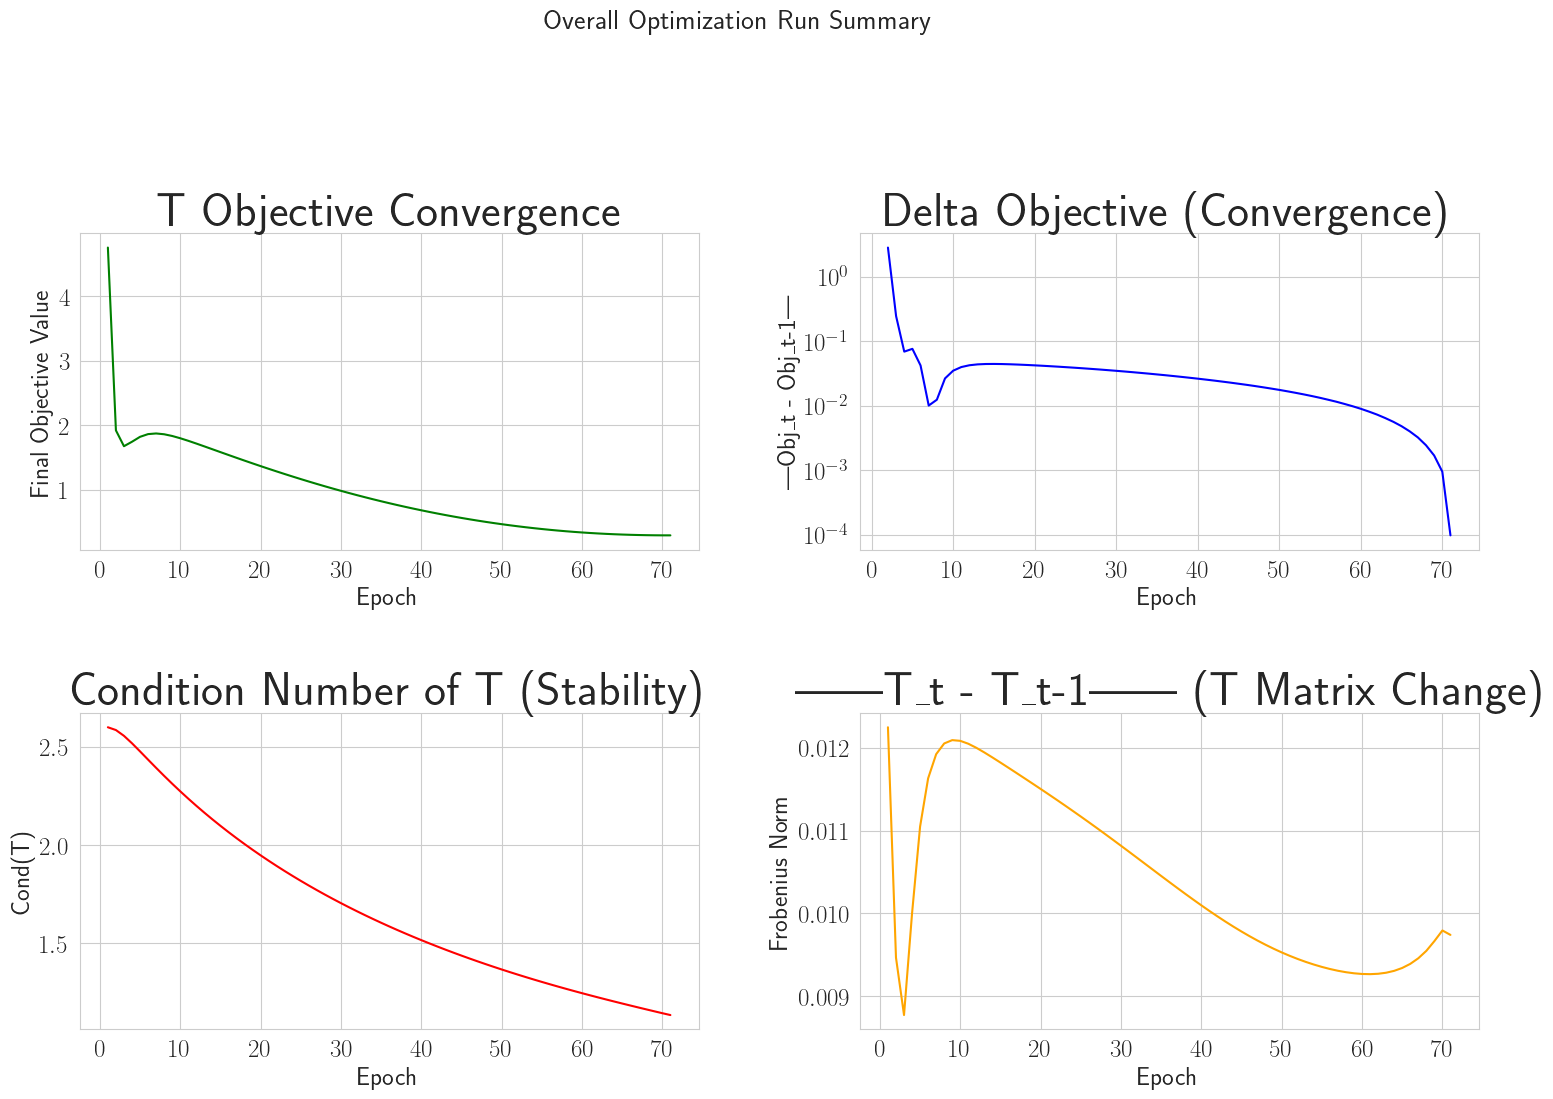

In [73]:
diroca_cv_results['fold_1']['eps_delta_4']['monitor'].plot_run_summary()

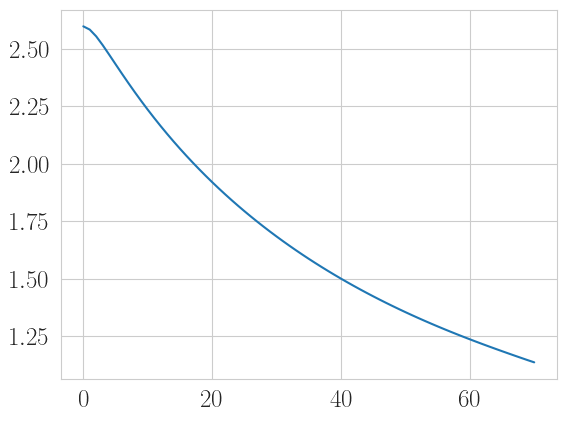

Final Condition Number for eps_delta_8 in fold_0: 1.1358


In [81]:
# 1. Choose a specific result to inspect
fold_key = 'fold_0'
run_key = 'eps_delta_8' # Example run
result = diroca_cv_results[fold_key][run_key]

# 2. Access the monitor object
monitor = result['monitor']

# 3. Get the list of condition numbers recorded during training
condition_number_history = monitor.condition_numbers

plt.plot(condition_number_history)
plt.show()
# 4. The final condition number is the last element in the list
final_condition_number = condition_number_history[-1]

print(f"Final Condition Number for {run_key} in {fold_key}: {final_condition_number:.4f}")

In [59]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

def plot_marginal_distributions(final_params, initial_params, var_names, model_name=""):
    """Plots a comparison of the 1D marginals for each variable."""

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 40,
        "axes.titlesize": 34,
        "axes.labelsize": 18,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.fontsize": 24,
        "figure.titlesize": 22
    })
    
    mu_final, sigma_final = final_params['mu_U'], final_params['Sigma_U']
    mu_initial, sigma_initial = initial_params['mu_U'], initial_params['Sigma_U']
    
    n_vars = len(var_names)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()
    #fig.suptitle(f'Marginal Noise Distributions: {model_name}', fontsize=20)
    initial_color = 'skyblue'  # a softer blue
    worst_color = 'mediumorchid'    # a softer red
    legend_color = '#000000'    # a softer red

    # Use these to collect one example of each line for legend
    legend_handles = None

    for i in range(n_vars):
        mean_i, std_i = mu_initial[i], np.sqrt(sigma_initial[i, i])
        x = np.linspace(mean_i - 3*std_i, mean_i + 3*std_i, 200)
        line1, = axes[i].plot(x, norm.pdf(x, mean_i, std_i), initial_color, lw=3, label='Initial (Empirical)')

        mean_f, std_f = mu_final[i], np.sqrt(sigma_final[i, i])
        x = np.linspace(mean_f - 3*std_f, mean_f + 3*std_f, 200)
        line2, = axes[i].plot(x, norm.pdf(x, mean_f, std_f), worst_color, linestyle='--', lw=3, label='Final (Worst-Case)')

        axes[i].set_title(var_names[i], fontsize=18)
        axes[i].tick_params(axis='both', which='major', labelsize=14)

        # Store legend handles from the first plot
        if legend_handles is None:
            legend_handles = [line1, line2]

    # Hide any unused subplots
    for j in range(n_vars, len(axes)):
        fig.delaxes(axes[j])

    # Add a single legend at the bottom
    fig.legend(legend_handles, ['Initial (Empirical)', 'Final (Worst-Case)'],
               loc='lower center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 0.0))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to fit legend
    plt.show()


In [68]:
fold_to_inspect = 'fold_0'
hyperparam_to_inspect = 'eps_delta_8' # Use a key that exists in your results

result = diroca_cv_results[fold_to_inspect][hyperparam_to_inspect]
monitor = result['monitor']

fold_info = saved_folds[int(fold_to_inspect.split('_')[1])]

initial_params = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)

initial_params_L = initial_params['theta_hatL']
initial_params_H = initial_params['theta_hatH']

final_params = result['optimization_params']



--- Distribution Summary: Low-Level Model ---

Mean (μ):
  - Initial: [0 0 0]
  - Final  : [ 0.142 -0.142  0.142]

Variances (diag(Σ)):
  - Initial: [1 1 1]
  - Final  : [6.676 0.534 4.758]

Final Correlation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
----------------------------------------


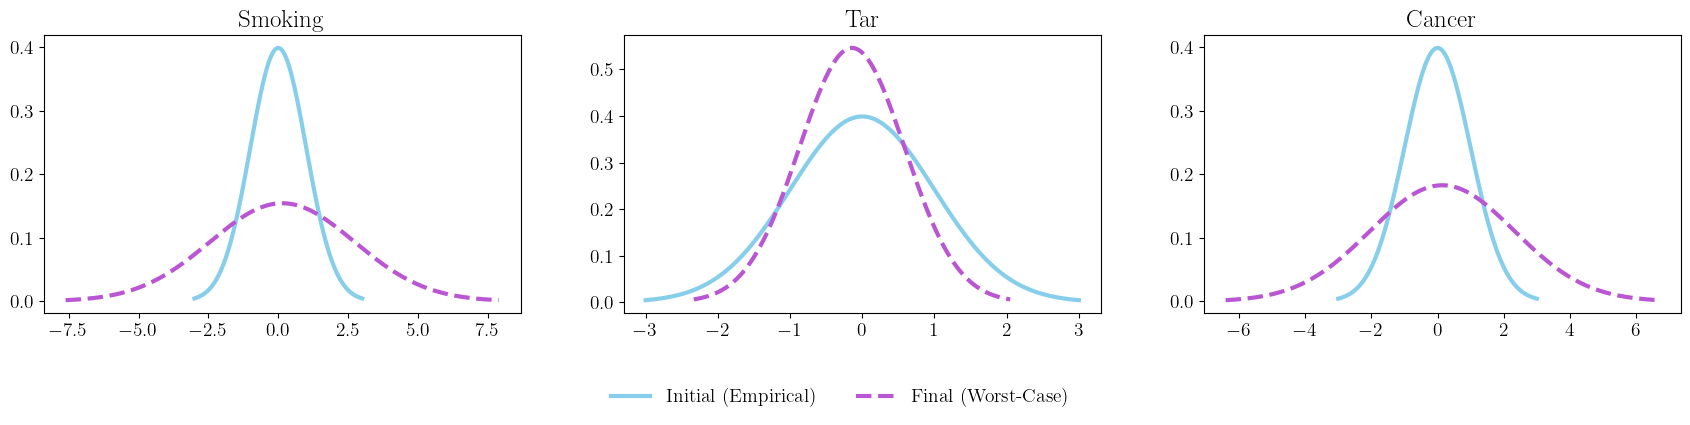


--- Distribution Summary: High-Level Model ---

Mean (μ):
  - Initial: [0.02 0.  ]
  - Final  : [0.162 0.142]

Variances (diag(Σ)):
  - Initial: [8.601 0.239]
  - Final  : [7.626 7.626]

Final Correlation Matrix:
[[1. 0.]
 [0. 1.]]
-----------------------------------------


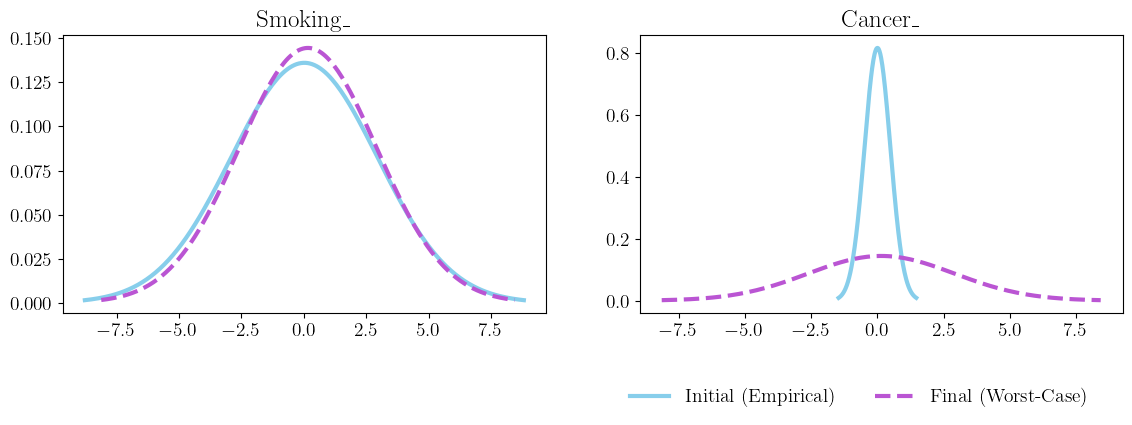

In [67]:
# Print the Numerical Summary for both LL and HL models and plot the marginal distributions
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

ut.print_distribution_summary(final_params['L'], initial_params_L, name="Low-Level Model")
plot_marginal_distributions(final_params['L'], initial_params_L, ll_var_names, model_name="Low-Level Model")


ut.print_distribution_summary(final_params['H'], initial_params_H, name="High-Level Model")
plot_marginal_distributions(final_params['H'], initial_params_H, hl_var_names, model_name="High-Level Model")

Total Trajectory Length (Low-Level): 37.3093
Distribution Spread (Low-Level): μ-Spread=0.1714, Σ-Spread=6.0316


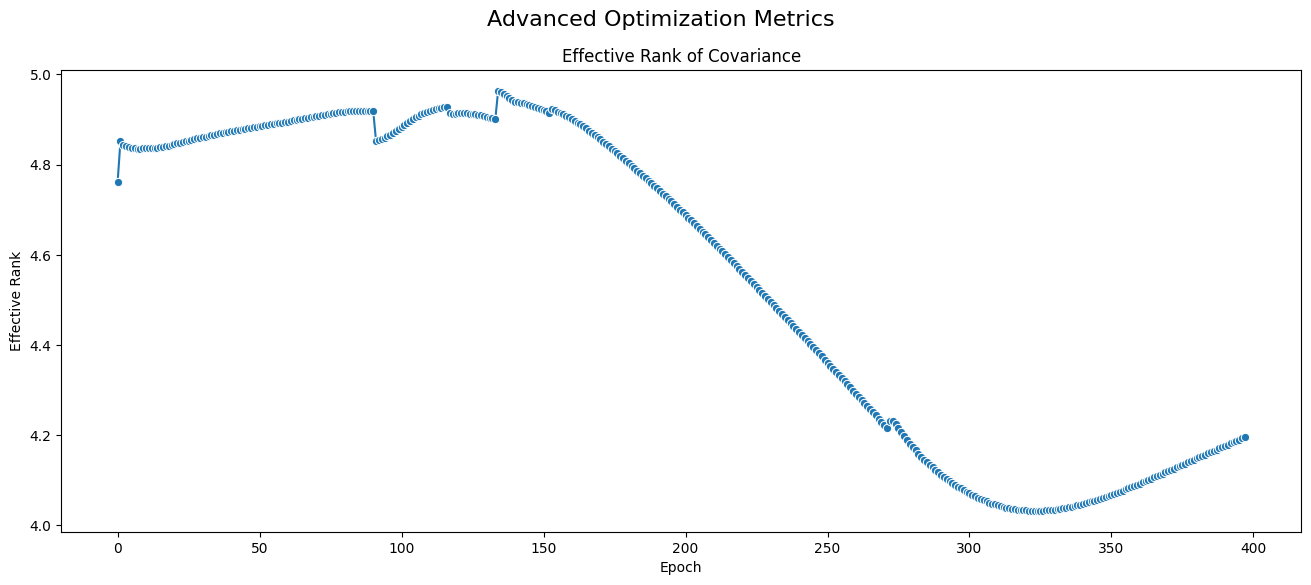

In [9]:
# Metric 1: Trajectory Length
traj_len = monitor.compute_trajectory_length(level='L')
print(f"Total Trajectory Length (Low-Level): {traj_len:.4f}")

# Metric 2: Diversity/Spread
spreads = monitor.compute_spread_metrics(level='L')
print(f"Distribution Spread (Low-Level): μ-Spread={spreads['spread_mu']:.4f}, Σ-Spread={spreads['spread_sigma']:.4f}")

# Metric 3: Effective Rank of Covariance
eff_ranks = monitor.compute_effective_rank_history(level='L')

fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle('Advanced Optimization Metrics', fontsize=16)

sns.lineplot(x=range(len(eff_ranks)), y=eff_ranks, marker='o', ax=ax)
ax.set_title('Effective Rank of Covariance')
ax.set_xlabel('Epoch')
ax.set_ylabel('Effective Rank')

plt.show()

In [ ]:
final_results_df['method'].unique()

array(['DIROCA (eps_delta_4)', 'DIROCA (eps_delta_8)',
       'DIROCA (eps_delta_1)', 'DIROCA (eps_delta_2)',
       'DIROCA (eps_delta_0.111)', 'GradCA', 'BARYCA'], dtype=object)

In [10]:
# ll_var_names = list(all_data['LLmodel']['graph'].nodes())
# ut.create_optimization_animation(monitor, initial_params, ll_var_names, model_level='L', filename='ll_optimization.gif')

# hl_var_names = list(all_data['HLmodel']['graph'].nodes())
# ut.create_optimization_animation(monitor, initial_params, hl_var_names, model_level='H', filename='hl_optimization.gif')

### 2. GRADCA optimization

In [5]:
gradca_cv_results = {}

# 2. Outer Loop: Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    gradca_cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])

    # Assemble parameters for this specific run
    params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_gradca)
   
    # Prepare arguments for the optimization function
    opt_args = params_for_this_run.copy()
    opt_args.pop('k_folds', None)
    
    # Run the optimization
    trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)

    # Store the results
    gradca_cv_results[fold_key] = {
        'gradca_run': {
            'T_matrix': trained_T,
            'test_indices': fold_info['test'] 
        }
    }
    
print("\n\n--- Optimization Complete ---")


--- Starting Cross-Validation for Fold 1/5 ---
Running optimization on device: cpu


Optimizing:  14%|█▍        | 424/3000 [00:15<01:35, 26.87it/s]


KeyboardInterrupt: 

### 3. BARYCA optimization

In [ ]:
baryca_cv_results = {}

for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Barycentric Optimization for Fold {i+1}/{len(saved_folds)} ---")
    
    opt_args = ut.assemble_barycentric_parameters(fold_info, all_data, hyperparams_baryca)
    opt_args.pop('k_folds', None)

    # Run the optimization
    trained_params, trained_T = optools.barycentric_optimization(**opt_args)
    
    # Store the results 
    fold_key = f'fold_{i}'

    # Store the results
    baryca_cv_results[fold_key] = {
        'baryca_run': {
            'T_matrix': trained_T,
            'test_indices': fold_info['test'] 
        }
    }
print("\n\n--- Optimization Complete ---")


--- Starting Barycentric Optimization for Fold 1/2 ---

--- Starting Barycentric Optimization for Fold 2/2 ---


--- Optimization Complete ---


## Save the results

In [15]:
joblib.dump(diroca_cv_results, f"data/{experiment}/diroca_cv_results.pkl")
joblib.dump(gradca_cv_results, f"data/{experiment}/gradca_cv_results.pkl")
joblib.dump(baryca_cv_results, f"data/{experiment}/baryca_cv_results.pkl")

print("All results have been saved successfully!")

All results have been saved successfully!
